In [69]:
import torch
from torch import nn, optim
import numpy as np

def create_model(num_features, sequence_len, channels, k):
    network = nn.Sequential()

    c, h, w = channels, sequence_len, num_features
    print(c, h, w)
    
    # first convolutional layer, followed by relu and maxpooling layers
    network.add_module('Conv1', nn.Conv2d(in_channels=channels, out_channels=4*channels, kernel_size=(1, num_features)))
    c, h, w = 4*c, h, 1
    print(c, h, w)

    network.add_module('Conv2', nn.Conv2d(in_channels=4*channels, out_channels=8*channels, kernel_size=(k, 1)))
    c, h = 2*c, h - k + 1
    print(c, h, w)
    
    network.add_module('ReLU1', nn.ReLU())
    network.add_module('MaxPool1', nn.MaxPool2d(kernel_size=(2,1), stride=2))
    h = h / 2
    print(c, h, w)
    
    # next layer, same thing.
    network.add_module('Conv3', nn.Conv2d(in_channels=8*channels, out_channels=16*channels, kernel_size=(k, 1)))
    c, h = 2*c, h - k + 1
    print(c, h, w)
    
    network.add_module('ReLU2', nn.ReLU())
    network.add_module('MaxPool2', nn.MaxPool2d(kernel_size=(2,1), stride=2))
    h = h / 2
    print(c, h, w)
    
    
    # then flatten everything into a single dimension and apply dropout
    network.add_module('Flatten', nn.Flatten())
    print(c * h * w)
    
    network.add_module('Dropout', nn.Dropout(0.2))
    
    # fully connected layers to produce a new set of features
    #flat_size = 16 * channels * ((sequence_len - k + 1) // 2 - k + 1) // 2
    network.add_module('FC1', nn.Linear(int(c*h*w), 512))
    network.add_module('ReLU3', nn.ReLU())
    network.add_module('FC2', nn.Linear(512, 128))
    network.add_module('ReLU4', nn.ReLU())
    network.add_module('FC3', nn.Linear(128, num_features))

    return network

In [59]:
import torch

def create_tensors(historical_data: pd.DataFrame, normal_data: pd.DataFrame):
    date_lookup = {}
    index = historical_data['DATE']
    for i in range(len(index)):
        date_lookup[index[i]] = i

    merged = pd.merge(historical_data, normal_data, on='DAY', how='left')
    mean_columns = [x for x in merged.columns if 'mean' in x]
    normals_for_historical = merged[['DATE', 'DAY'] + mean_columns]
    normals_for_historical.columns = historical_data.columns
    differences = historical_data.drop(['DATE', 'DAY'], axis=1).subtract(normals_for_historical.drop(['DATE', 'DAY'], axis=1))
    squared_differences = differences.pow(2)

    historical = historical_data.drop(['DATE', 'DAY'], axis=1)
    normal = normals_for_historical.drop(['DATE', 'DAY'], axis=1)

    h_tensors = torch.from_numpy(historical.values)
    n_tensors = torch.from_numpy(normal.values)
    d_tensors = torch.from_numpy(differences.values)
    s_tensors = torch.from_numpy(squared_differences.values)

    return torch.stack((h_tensors, n_tensors, d_tensors, s_tensors), dim=0), date_lookup


In [61]:
def get_historical_features(frm, tensors, date_lookup, input=False):
    if isinstance(frm, str):
        from_idx = date_lookup[frm]
    else:
        from_idx = frm
    if input:
        return tensors[:, from_idx, :]
    else:
        return tensors[0, from_idx, :]

def get_many_historical_features(frm, to, tensors, date_lookup, input=False):
    if isinstance(frm, str):
        from_idx = date_lookup[frm]
    else:
        from_idx = frm

    if isinstance(to, str):
        to_idx = date_lookup[to]
    else:
        to_idx = to

    data = []
    for idx in range(from_idx, to_idx + 1, 1):
        if input:
            data.append(tensors[:, idx, :])
        else:
            data.append(tensors[0, idx, :])

    if input:
        return torch.stack(data, dim=1)
    else:
        return torch.stack(data, dim=0)

def create_features_datasets(tensors, date_lookup, backward_features, forward_features):
    first_idx = backward_features + 1
    last_idx = tensors.size()[1] - forward_features - 1
    
    X = []
    Y = []

    for idx in range(first_idx, last_idx, 1):
        if backward_features > 0 and forward_features > 0:
            backward = get_many_historical_features(idx - backward_features, idx - 1, tensors, date_lookup, input=True)
            forward = get_many_historical_features(idx + 1, idx + forward_features, tensors, date_lookup, input=True)            
            input_features = torch.concat((backward, forward), dim=1)
        elif backward_features > 0:
            input_features = get_many_historical_features(idx - backward_features, idx - 1, tensors, date_lookup, input=True)
        elif forward_features > 0:
            input_features = get_many_historical_features(idx + 1, idx + forward_features, tensors, date_lookup, input=True)            

        output_features = get_historical_features(idx, tensors, date_lookup, input=False)

        X.append(input_features)
        Y.append(output_features)
    
    return torch.stack(X, dim=0), torch.stack(Y, dim=0)

In [ ]:
import torch.utils.data as Data
import pandas as pd
import torch
from torch import nn, optim
import numpy as np
import os

historical_data = r"data\grand_island_nwt.csv"
normals_data = r"data\grand_island_normals.csv"

historical = pd.read_csv(historical_data)
normals = pd.read_csv(normals_data)
normals.insert(0, 'DAY', normals.index)

print('Creating tensors')
t, dl = create_tensors(historical, normals)

print('Creating feature datasets')
forward_features, backward_features = 0, 60
X, Y = create_features_datasets(t.float(), dl, backward_features, forward_features)

start_train_date = '1984-01-01'
end_train_date = '2005-01-01' # not inclusive
start_val_date = '2005-01-01'
end_val_date = '2011-01-01'   # not inclusive

start_train_idx = dl[start_train_date]
end_train_idx = dl[end_train_date]
start_val_idx = dl[start_val_date]
end_val_idx = dl[end_val_date]

#train_len = int(0.7 * X.size()[0])
X_train, Y_train = X[start_train_idx:end_train_idx], Y[start_train_idx:end_train_idx]
X_test, Y_test = X[start_val_idx:end_val_idx], Y[start_val_idx:end_val_idx]

print('Creating data loader')
dataset = Data.TensorDataset(X, Y)

batch_size = 4
loader = Data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

print('Initializing model')
model = create_model(13, forward_features + backward_features, 4, 5)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print('Begin training')
n_epochs = 1000

batch_training_losses = np.zeros(n_epochs)
training_losses = np.zeros(n_epochs)
testing_losses = np.zeros(n_epochs)

best_test_rmse = 1_000_000

for epoch in range(n_epochs):
    model.train()
    b = 0
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        batch_training_losses[epoch] += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        b += 1
    training_losses[epoch] /= b
    
    # Validation
    model.eval()
    with torch.no_grad():
        Y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(Y_pred, Y_train))
        training_losses[epoch] = np.square(train_rmse)
        Y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(Y_pred, Y_test))
        testing_losses[epoch] = np.square(test_rmse)
    
    if (epoch + 1) % 5 == 0:
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch+1, train_rmse, test_rmse))

    if test_rmse < best_test_rmse:
        best_test_rmse = test_rmse
        print("Checkpointing at epoch %d with test RMSE %.4f" % (epoch + 1, test_rmse))
        save_path = os.path.join('models', f'model_f{forward_features}_b{backward_features}_e{epoch+1}.mdl')
        torch.save(model.state_dict(), save_path)


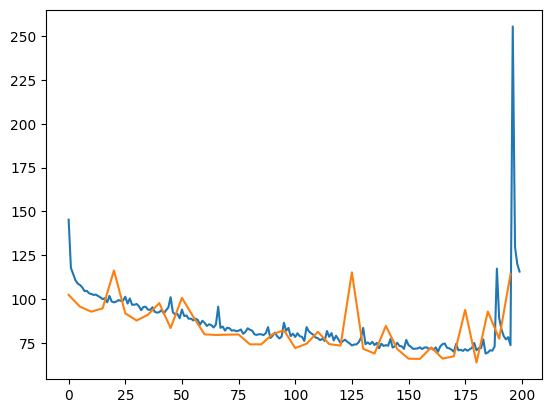

In [110]:
import matplotlib.pyplot as plt

plt.plot(range(len(training_losses)), training_losses)
plt.plot(range(0, len(testing_losses), 5), testing_losses[4::5])
plt.show()

In [116]:
dl['2010-01-01']

9497